In [23]:
import sys
sys.path.insert(0, "D:\\Documents\\food_recipe_gen\\recipe_1m_analysis")
import os
import pandas as pd
import torch
import utils
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data preprocessing

In [24]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILES = ["random_data.pkl","cluster_centroid_data.pkl","full_data.pkl"]
balanced = True

In [25]:
# TODO put together both datasets (same method of undersampling, or undersample afterwards ?) & test
df=pd.read_pickle(os.path.join(FOLDER_PATH,DATASET[1],FILES[2]))
df=df.reset_index()
df

,index,id,cuisine,ingredients,all_ingredients
0,0,0,Italian,"[baby bella mushroom sliced, arborio rice, oli...",baby bella mushroom sliced;arborio rice;olive ...
1,2,2,Italian,"[garlic, extra-virgin olive oil divided, madei...",garlic;extra-virgin olive oil divided;madeira ...
2,3,3,French,"[garlic halved, cooking spray, peeled red pota...",garlic halved;cooking spray;peeled red potato;...
3,5,5,American,"[turkey thawed, maple syrup, bourbon, pickling...",turkey thawed;maple syrup;bourbon;pickling spi...
4,6,6,American,"[beef tenderloin silver skin trimmed, worceste...",beef tenderloin silver skin trimmed;worcesters...
...,...,...,...,...,...
26321,27633,27633,Italian,"[zwiebeln, knoblauchzehen, dose dicke weisse b...",zwiebeln;knoblauchzehen;dose dicke weisse bohn...
26322,27634,27634,American,"[fresh lavender blossom, sugar, carrot juice, ...",fresh lavender blossom;sugar;carrot juice;pota...
26323,27635,27635,French,"[gr. bread flour, ml. water, gr. yeast, gr. st...",gr. bread flour;ml. water;gr. yeast;gr. strong...
26324,27636,27636,American,"[flour, unsweetened cocoa powder, baking soda,...",flour;unsweetened cocoa powder;baking soda;sal...


In [26]:
vocab_ingrs = utils.Vocabulary()
for ingredients in df.loc[:,"ingredients"]:
    for ingr in ingredients:
        vocab_ingrs.add_word(ingr)
vocab_ingrs.add_word("<unk>")
vocab_ingrs.word2idx

{'baby bella mushroom sliced': 0,
 'arborio rice': 1,
 'olive oil': 2,
 'butter': 3,
 'shallot minced': 4,
 'white wine': 5,
 'fat free chicken stock': 6,
 'salt pepper': 7,
 'grated parmesan cheese': 8,
 'chopped parsley': 9,
 'garlic': 10,
 'extra-virgin olive oil divided': 11,
 'madeira divided': 12,
 'unsalted chicken stock divided': 13,
 'dried porcini mushroom': 14,
 'chopped onion': 15,
 'thinly sliced cremini mushroom': 16,
 'thinly sliced shiitake mushroom cap': 17,
 'uncooked arborio rice': 18,
 'parmesan cheese grated': 19,
 'kosher salt': 20,
 'freshly ground black pepper': 21,
 'chopped fresh sage': 22,
 'sage': 23,
 'garlic halved': 24,
 'cooking spray': 25,
 'peeled red potato': 26,
 'butter melted': 27,
 'salt': 28,
 'black pepper': 29,
 'shredded gruyere cheese': 30,
 'fat-free milk': 31,
 'turkey thawed': 32,
 'maple syrup': 33,
 'bourbon': 34,
 'pickling spice': 35,
 'large carrot scraped': 36,
 'celery rib': 37,
 'medium onion peeled halved': 38,
 'lemon': 39,
 'pep

In [27]:
vocab_cuisine = utils.Vocabulary()
for cuisine in df['cuisine'].value_counts().index:
    vocab_cuisine.add_word(cuisine)
vocab_cuisine.word2idx

{'American': 0,
 'Italian': 1,
 'Mexican': 2,
 'Asian': 3,
 'French': 4,
 'Indian': 5,
 'Mediterranean': 6,
 'Spanish_Portuguese': 7,
 'Cuban': 8,
 'English_Irish': 9,
 'Moroccan': 10}

## Data processing

In [28]:
def ingr2idx(ingr_list):
    # If I didn't do the one-hot encoding by myself and used directly an embedding layer in the net, 
    # I would have to pad the input
    input_=[]
    for ingr in ingr_list:
        try:
            input_.append(vocab_ingrs.word2idx[ingr])
        except KeyError:
            input_.append(vocab_ingrs.word2idx["<unk>"])
    input_ = torch.LongTensor(input_)
    onehot_enc = F.one_hot(input_.to(torch.int64), INPUT_SIZE)
    output = torch.sum(onehot_enc,0)
    return output

class RecipesDataset(Dataset):
    """Recipes dataset for cuisine classification. Only from ingredients for now"""

    def __init__(self, input_,labels):
        """
        Args:
            file (string): Path to the file
        """
        self.input_ = input_
        self.labels = labels

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        # XXX useful ?
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ingr_one_hot = ingr2idx(self.input_.loc[idx,"ingredients"])
        label = vocab_cuisine.word2idx[self.labels.loc[idx,"cuisine"]]

        return ingr_one_hot, label

In [29]:
def make_weights_for_balanced_classes(samples, nclasses): 
    count = [0] * nclasses
    weight_per_class = [0.] * nclasses
    N = len(samples)
    
    for a,el in samples.value_counts().items():
        count[vocab_cuisine.word2idx[a]]=el

    for i in range(nclasses): # to still sample the others, add log ? so goes back to N, not max(count)
        weight_per_class[i] = math.log(N/float(count[i])) # divide by max count[i] ? Or just different scale, order is same
        print(vocab_cuisine.idx2word[i], weight_per_class[i])
    weight = [0] * N
    
    for idx, val in enumerate(samples): 
        weight[idx] = weight_per_class[vocab_cuisine.word2idx[val]] 
        
    
    return torch.Tensor(weight_per_class), torch.DoubleTensor(weight)

# from https://gist.github.com/srikarplus/15d7263ae2c82e82fe194fc94321f34e

In [30]:
INPUT_SIZE = len(vocab_ingrs)
EMBED_DIM1 = 300
EMBED_DIM2 = 64
NUM_CLASSES = len(vocab_cuisine) #51 or 20
BATCH_SIZE = 100
PRINT_FREQ = 20
NB_EPOCHS = 50

Weighted random sampling, with stratified split for the train and test dataset. But loss doesn't decrease (need to see more epochs ?)

In [31]:
#TODO when switch to python file, can put num_workers & have to put if __name__ == '__main__':
X_train, X_dev, y_train, y_dev = train_test_split(df["ingredients"],df["cuisine"], test_size=0.1, random_state=42,stratify=df["cuisine"])

X_train = X_train.reset_index()
X_dev = X_dev.reset_index()
y_train = y_train.reset_index()
y_dev = y_dev.reset_index()

train_dataset = RecipesDataset(X_train,y_train)
dev_dataset = RecipesDataset(X_dev,y_dev)

if balanced:
    weights_classes, weights_labels = make_weights_for_balanced_classes(y_train["cuisine"], len(vocab_cuisine.word2idx)) 
    print(len(weights_labels))
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_labels, len(weights_labels)) 
    train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE, sampler = sampler)#, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE)#, pin_memory=True)    

dev_loader = DataLoader(dev_dataset,batch_size = 1)

American 0.7941885202062338
Italian 1.7507838546335746
Mexican 1.8856356546913298
Asian 2.324906400414101
French 2.824430852475867
Indian 2.894389441082777
Mediterranean 5.152953999018352
Spanish_Portuguese 6.083950878282202
Cuban 6.740730414671273
English_Irish 7.5079855673849405
Moroccan 7.770349831852431
23693


In [32]:
# # Random split, but loss decreases...

# dataset = RecipesDataset(df[["ingredients","cuisine"]],df[["ingredients","cuisine"]])
# train_d,test_d = torch.utils.data.random_split(dataset, [len(dataset)-1000,1000])
# train_loader = DataLoader(train_d,batch_size = BATCH_SIZE, shuffle = True)
# test_loader = DataLoader(test_d, batch_size=1)

# Model

In [33]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim1, embedding_dim2, num_classes):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(vocab_size, embedding_dim1, bias=True)
        self.layer_2 = nn.Linear(embedding_dim1, embedding_dim1, bias=True)
#         self.layer_3 = nn.Linear(embedding_dim1, embedding_dim2, bias=True)
        self.output_layer = nn.Linear(embedding_dim1, num_classes, bias=True)

    def forward(self, x):
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
#         out = F.relu(self.layer_3(out))
        out = self.output_layer(out)
        return out

net = Net(INPUT_SIZE, EMBED_DIM1, EMBED_DIM2, NUM_CLASSES)

## Training

In [34]:
if balanced:
    criterion = nn.CrossEntropyLoss(weights_classes)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #change to Adam ?

In [35]:
epoch_accuracy = []

for epoch in range(NB_EPOCHS):

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0]
        labels = data[1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_FREQ == PRINT_FREQ-1:    # print every 2000 mini-batches
            print(f'[Epoch {epoch + 1}, Iteration {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        
        accuracy = 100 * correct / total
    epoch_accuracy.append(accuracy)
    
    print(f'Accuracy of the network on epoch {epoch+1}: {accuracy:.3f}')

print('Finished Training')

[Epoch 1, Iteration 20] loss: 0.024
[Epoch 1, Iteration 40] loss: 0.023
[Epoch 1, Iteration 60] loss: 0.022
[Epoch 1, Iteration 80] loss: 0.022
[Epoch 1, Iteration 100] loss: 0.021
[Epoch 1, Iteration 120] loss: 0.021
[Epoch 1, Iteration 140] loss: 0.021
[Epoch 1, Iteration 160] loss: 0.021
[Epoch 1, Iteration 180] loss: 0.021
[Epoch 1, Iteration 200] loss: 0.021
[Epoch 1, Iteration 220] loss: 0.020
Accuracy of the network on epoch 1: 28.418
[Epoch 2, Iteration 20] loss: 0.020
[Epoch 2, Iteration 40] loss: 0.018
[Epoch 2, Iteration 60] loss: 0.018
[Epoch 2, Iteration 80] loss: 0.017
[Epoch 2, Iteration 100] loss: 0.016
[Epoch 2, Iteration 120] loss: 0.015
[Epoch 2, Iteration 140] loss: 0.014
[Epoch 2, Iteration 160] loss: 0.013
[Epoch 2, Iteration 180] loss: 0.012
[Epoch 2, Iteration 200] loss: 0.012
[Epoch 2, Iteration 220] loss: 0.012
Accuracy of the network on epoch 2: 56.249
[Epoch 3, Iteration 20] loss: 0.010
[Epoch 3, Iteration 40] loss: 0.011
[Epoch 3, Iteration 60] loss: 0.011


[Epoch 19, Iteration 40] loss: 0.000
[Epoch 19, Iteration 60] loss: 0.000
[Epoch 19, Iteration 80] loss: 0.000
[Epoch 19, Iteration 100] loss: 0.000
[Epoch 19, Iteration 120] loss: 0.000
[Epoch 19, Iteration 140] loss: 0.000
[Epoch 19, Iteration 160] loss: 0.000
[Epoch 19, Iteration 180] loss: 0.000
[Epoch 19, Iteration 200] loss: 0.000
[Epoch 19, Iteration 220] loss: 0.000
Accuracy of the network on epoch 19: 98.852
[Epoch 20, Iteration 20] loss: 0.000
[Epoch 20, Iteration 40] loss: 0.000
[Epoch 20, Iteration 60] loss: 0.000
[Epoch 20, Iteration 80] loss: 0.000
[Epoch 20, Iteration 100] loss: 0.000
[Epoch 20, Iteration 120] loss: 0.000
[Epoch 20, Iteration 140] loss: 0.000
[Epoch 20, Iteration 160] loss: 0.000
[Epoch 20, Iteration 180] loss: 0.000
[Epoch 20, Iteration 200] loss: 0.000
[Epoch 20, Iteration 220] loss: 0.000
Accuracy of the network on epoch 20: 98.953
[Epoch 21, Iteration 20] loss: 0.000
[Epoch 21, Iteration 40] loss: 0.000
[Epoch 21, Iteration 60] loss: 0.000
[Epoch 21,

Accuracy of the network on epoch 36: 99.793
[Epoch 37, Iteration 20] loss: 0.000
[Epoch 37, Iteration 40] loss: 0.000
[Epoch 37, Iteration 60] loss: 0.000
[Epoch 37, Iteration 80] loss: 0.000
[Epoch 37, Iteration 100] loss: 0.000
[Epoch 37, Iteration 120] loss: 0.000
[Epoch 37, Iteration 140] loss: 0.000
[Epoch 37, Iteration 160] loss: 0.000
[Epoch 37, Iteration 180] loss: 0.000
[Epoch 37, Iteration 200] loss: 0.000
[Epoch 37, Iteration 220] loss: 0.000
Accuracy of the network on epoch 37: 99.709
[Epoch 38, Iteration 20] loss: 0.000
[Epoch 38, Iteration 40] loss: 0.000
[Epoch 38, Iteration 60] loss: 0.000
[Epoch 38, Iteration 80] loss: 0.000
[Epoch 38, Iteration 100] loss: 0.000
[Epoch 38, Iteration 120] loss: 0.000
[Epoch 38, Iteration 140] loss: 0.000
[Epoch 38, Iteration 160] loss: 0.000
[Epoch 38, Iteration 180] loss: 0.000
[Epoch 38, Iteration 200] loss: 0.000
[Epoch 38, Iteration 220] loss: 0.000
Accuracy of the network on epoch 38: 99.759
[Epoch 39, Iteration 20] loss: 0.000
[Ep

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


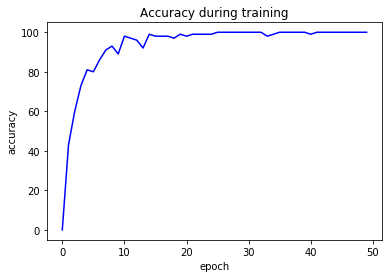

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
x_points = [i for i in range(0,NB_EPOCHS)]
epoch_accuracy2=[]
for i in range(len(epoch_accuracy)):
    if i%237==0:
        epoch_accuracy2.append(epoch_accuracy[i])
p = ax.plot(x_points, epoch_accuracy2, 'b')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy during training')
fig.show()

In [37]:
torch.save(net.state_dict(), os.path.join(FOLDER_PATH,DATASET[1],"model_logweights"))

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(FOLDER_PATH,DATASET[1],"training_state_logweights"))

# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## Testing on dev set

In [38]:
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [39]:
def score(network, dataloader):

    correct = 0
    total = 0
    all_predict = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]
            labels = data[1]
            outputs = network(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            all_predict.append(predicted)
            all_labels.append(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(predicted)
    accuracy= 100 * correct / total
    print(f'Accuracy of the network on the dataset: {accuracy:.3f} %')

    one_hot_pred = F.one_hot(torch.LongTensor(all_predict).to(torch.int64), NUM_CLASSES)
    one_hot_lab = F.one_hot(torch.LongTensor(all_labels).to(torch.int64), NUM_CLASSES)
    fbeta_pytorch = f2_score(one_hot_pred, one_hot_lab)

    print(f'Score is {100* fbeta_pytorch:.3f} %')
    
    return accuracy, fbeta_pytorch

dev_accuracy, dev_fscore = score(net,dev_loader)

tensor([2])
Accuracy of the network on the dataset: 83.099 %
Score is 83.099 %


## On test set

In [41]:
df_test=pd.read_pickle(os.path.join(FOLDER_PATH,DATASET[0],FILES[1]))
df_test_s=df_test.sample(1000)
df_test_s=df_test_s.reset_index()

test_dataset=RecipesDataset(df_test_s["ingredients"],df_test_s["cuisine"])

test_loader = DataLoader(test_dataset, batch_size=1)#, sampler = sampler)

,level_0,index,cuisine,id,ingredients,all_ingredients,american_id
0,56612,56616,western,1383,"[olive_oil, lemon_juice, wheat, mustard, vineg...",olive_oil;lemon_juice;wheat;mustard;vinegar;ma...,NaN
1,55328,55332,Mexican,99,"[cheese, mushroom, onion, cayenne, corn, raisi...",cheese;mushroom;onion;cayenne;corn;raisin;pars...,NaN
2,57325,57329,Korean,2096,[honey],honey,NaN
3,2899,2903,Italian,2903,"[tomato, olive_oil, chicken, garlic, basil]",tomato;olive_oil;chicken;garlic;basil,NaN
4,41807,41811,Japanese,41811,"[mushroom, onion, beef, starch, nut, scallion,...",mushroom;onion;beef;starch;nut;scallion;celery...,NaN
...,...,...,...,...,...,...,...
995,1335,1339,French,1339,"[butter, wheat, cocoa, hazelnut, banana, cream]",butter;wheat;cocoa;hazelnut;banana;cream,NaN
996,54883,54887,Asian,13062,[soybean],soybean,NaN
997,4038,4042,South-America,4042,"[vanilla, milk]",vanilla;milk,NaN
998,54113,54117,Asian,12292,"[vinegar, coconut, soy_sauce, cilantro, ginger...",vinegar;coconut;soy_sauce;cilantro;ginger;lett...,NaN


In [42]:
test_accuracy, test_fscore = score(net,test_loader)

IndexingError: Too many indexers